In [10]:
import pandas as pd

# Load the Excel file
file_path = '/Users/sishengliang/Desktop/Intern SF/Anomaly Detection in GL/Data file for students.xlsx'
excel_data = pd.ExcelFile(file_path)

# Load the "GL" sheet
gl_data = pd.read_excel(file_path, sheet_name='GL')

# Calculate the IQR for each Account_key's Details corresponding 'Amount'
def calculate_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return IQR, Q1, Q3

# Function to identify outliers using IQR
def identify_outliers(data, Q1, Q3, IQR):
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

# Group data by Account_key and Details
grouped_data = gl_data.groupby(['Account_key', 'Details'])

# Initialize results dictionary
results = []

# Iterate through each group and calculate outliers
for (account_key, details), group in grouped_data:
    amount_data = group['Amount']
    IQR, Q1, Q3 = calculate_iqr(amount_data)
    outliers = identify_outliers(amount_data, Q1, Q3, IQR)
    
    # Append results
    results.append({
        'Account_key': account_key,
        'Details': details,
        'Total Data Points': len(amount_data),
        'Number of Outliers': len(outliers)
    })

# Convert results to DataFrame for display
results_df = pd.DataFrame(results)

In [14]:
#generate the output excel file of results_df
results_df.to_excel('/Users/sishengliang/Desktop/Intern SF/Anomaly Detection in GL/Anomaly Detection Results.xlsx', index=False)

In [11]:
def display_outliers_summary(gl_data, account_key, details):
    # Filter data based on the specified Account_key and Details
    filtered_data = gl_data[(gl_data['Account_key'] == account_key) & (gl_data['Details'] == details)]
    
    # Check if the filtered data is empty
    if filtered_data.empty:
        print(f"No data found for Account_key: {account_key} and Details: {details}")
        return
    
    # Calculate IQR and identify outliers
    amount_data = filtered_data['Amount']
    IQR, Q1, Q3 = calculate_iqr(amount_data)
    outliers = identify_outliers(amount_data, Q1, Q3, IQR)
    
    # Create a summary DataFrame
    summary = pd.DataFrame({
        'Account_key': [account_key],
        'Details': [details],
        'Total Data Points': [len(amount_data)],
        'Number of Outliers': [len(outliers)]
    })
    
    # Display the summary
    print(summary)

   Account_key     Details  Total Data Points  Number of Outliers
0          210  Cash Sales                882                  25


In [13]:
# Example usage
display_outliers_summary(gl_data, 210, 'Credit Sales')

   Account_key       Details  Total Data Points  Number of Outliers
0          210  Credit Sales               1386                  66


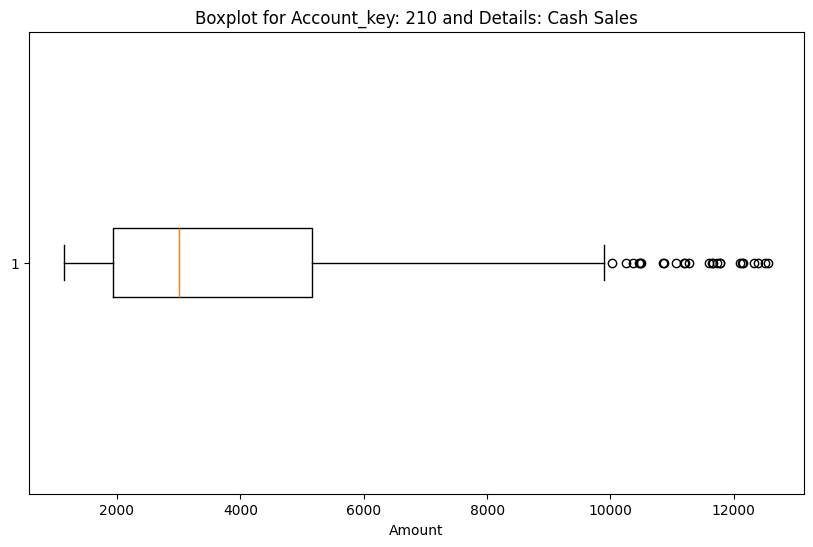

In [12]:
import matplotlib.pyplot as plt

def show_boxplot(gl_data, account_key, details):
    # Filter data based on the specified Account_key and Details
    filtered_data = gl_data[(gl_data['Account_key'] == account_key) & (gl_data['Details'] == details)]
    
    # Check if the filtered data is empty
    if filtered_data.empty:
        print(f"No data found for Account_key: {account_key} and Details: {details}")
        return
    
    # Create a boxplot for the Amount column of the filtered data
    plt.figure(figsize=(10, 6))
    plt.boxplot(filtered_data['Amount'], vert=False)
    plt.title(f'Boxplot for Account_key: {account_key} and Details: {details}')
    plt.xlabel('Amount')
    plt.show()

# Example usage
show_boxplot(gl_data, 210, 'Cash Sales')